# infoNCE, Informative Noise Contrastive Estimation by @marcopra

In [3]:
import gymnasium as gym
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

env = gym.make('Hopper-v4')


/home/mprattico/miniconda3/envs/cleanrl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_dataset(file_path):
    with open(file_path, "rb") as f:
        dataset = pickle.load(f)
    states, actions, next_states, rewards = zip(*dataset)
    
    # Convert to NumPy arrays for easier processing
    states = np.squeeze(np.array(states))
    actions = np.squeeze(np.array(actions))
    next_states = np.squeeze(np.array(next_states))
    rewards = np.squeeze(np.array(rewards))

    return states, actions, next_states, rewards


### Embedders
State-action embedder $\phi: \mathcal{S} \times \mathcal{A} \rightarrow  \mathbb{R}^d$
Next state embedder $\phi: \mathcal{S} \rightarrow  \mathbb{R}^d$

### Linear 

Theta network for learning reward function $r(s,a) = <\phi(s,a), \theta>$

In [5]:
class Phi(nn.Module):
    """
    phi: s, a -> z_phi in R^d
    """
    def __init__(
        self, 
        state_dim,
        action_dim,
        feature_dim=1024,
        hidden_dim=1024,
        ):

        super(Phi, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, feature_dim)

    def forward(self, state, action):
        x = torch.cat([state, action], axis=-1)
        z = F.elu(self.l1(x)) 
        z = F.elu(self.l2(z)) 
        z_phi = self.l3(z)
        z_phi = F.normalize(z_phi, p=2, dim=-1)
        return z_phi

class Mu(nn.Module):
    """
    mu': s' -> z_mu in R^d
    """
    def __init__(
        self, 
        state_dim,
        feature_dim=1024,
        hidden_dim=1024,
        ):

        super(Mu, self).__init__()

        self.l1 = nn.Linear(state_dim , hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, feature_dim)

    def forward(self, state):
        z = F.elu(self.l1(state))
        z = F.elu(self.l2(z))
        # bounded mu's output
        z_mu = F.tanh(self.l3(z)) 
        z_mu = F.normalize(z_mu, p=2, dim=-1)
        # z_mu = self.l3(z)
        return z_mu
     
class Theta(nn.Module):
    """
    Linear theta 
    <phi(s, a), theta> = r 
    """
    def __init__(
        self, 
        feature_dim=1024,
        ):

        super(Theta, self).__init__()

        self.l = nn.Linear(feature_dim, 1)

    def forward(self, feature):
        r = self.l(feature)
        return r

state_dim =  env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
phi = Phi(state_dim=state_dim, action_dim=action_dim)
mu = Mu(state_dim=state_dim)
theta = Theta()

# optimizer
phi_optimizer = torch.optim.Adam(phi.parameters(), lr=1e-3)
mu_optimizer = torch.optim.Adam(mu.parameters(), lr=1e-3)
theta_optimizer = torch.optim.Adam(theta.parameters(), lr=1e-3)

In [6]:
def infoNCEloss(z_phi, z_mu):
    """
    InfoNCE loss
    """

    # Cosine between all combinations
    logits = z_phi @ z_mu.T

    # Positive keys are the entries on the diagonal
    labels = torch.arange(len(z_phi))

    return F.cross_entropy(logits, labels, reduction='mean')


    f_x_c = torch.matmul(z_phi, z_mu.T)
    f_x_c_softmax = F.softmax(f_x_c, dim=-1)*torch.eye(f_x_c.shape[0])
    loss = torch.mean(-torch.log(torch.sum(f_x_c_softmax, dim=-1)))

    return -torch.log(F.softmax(f_x_c, dim=-1))*torch.eye(f_x_c.shape[0])


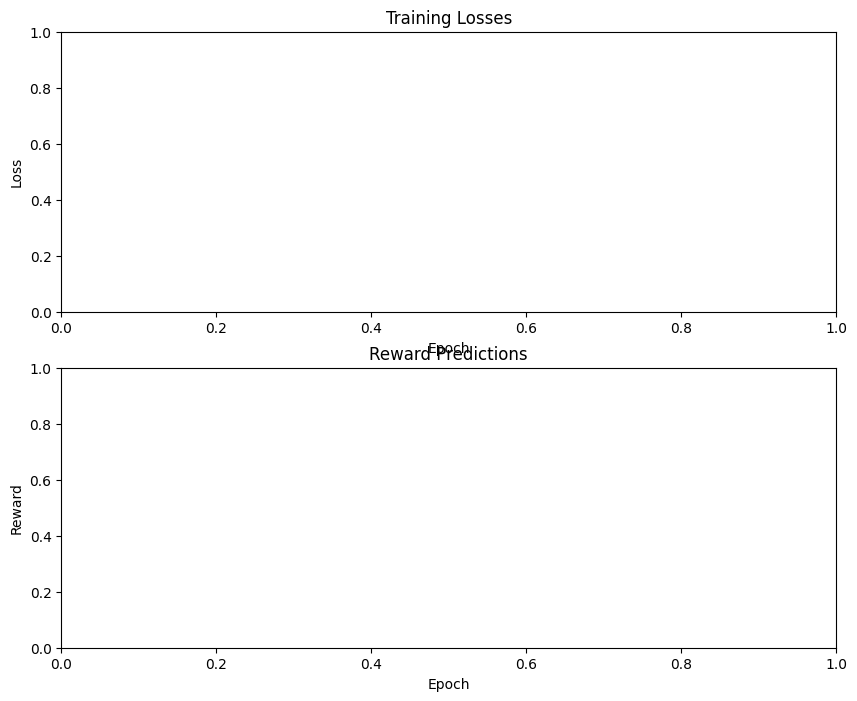

In [7]:
# Initialize Variables

# Initialize lists to store training losses and reward predictions
training_losses = []
reward_predictions = []

# Initialize a figure for plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Set titles for the subplots
ax1.set_title('Training Losses')
ax2.set_title('Reward Predictions')

# Set labels for the axes
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Reward')



# Define a function to update the plots progressively
def update_plots(epoch, loss, reward):
    # Append the new data to the lists
    training_losses.append(loss)
    reward_predictions.append(reward)
    
    # Clear the previous plots
    ax1.cla()
    ax2.cla()
    
    # Plot the updated data
    ax1.plot(training_losses, label='Loss')
    ax2.plot(reward_predictions, label='Reward')
    
    # Set titles and labels again after clearing
    ax1.set_title('Training Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_title('Reward Predictions')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Reward')
    
    # Add legends
    ax1.legend()
    ax2.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Clear the output and display the updated figure
    clear_output(wait=True)
    display(fig)

In [8]:
training_steps = 100000 
batch_size = 256
# Example usage:
file_path = "logs/dataset_Hopper-v4__sac_continuous_action__1__1738764694.pkl"  # Replace with actual run name
states, actions, next_states, rewards = load_dataset(file_path)

# # Display the figure
# plt.tight_layout()
# display(fig)

for epoch in range(training_steps):
    # sample a batch of transitions
    idx = np.random.choice(len(states), batch_size)
    batch_observations = torch.tensor(states[idx], dtype=torch.float32)
    batch_actions = torch.tensor(actions[idx], dtype=torch.float32)
    batch_next_observations = torch.tensor(next_states[idx], dtype=torch.float32)
    batch_rewards = torch.tensor(rewards[idx], dtype=torch.float32)

    # compute features
    z_phi = phi(batch_observations, batch_actions)

    z_mu = mu(batch_next_observations)
    # compute loss
    loss = infoNCEloss(z_phi, z_mu).mean()
    mu_optimizer.zero_grad()
    phi_optimizer.zero_grad()
    loss.backward()
    mu_optimizer.step()
    phi_optimizer.step()

    # compute reward
    with torch.no_grad():
        z_phi = phi(batch_observations, batch_actions)

    loss_r = F.mse_loss(theta(z_phi), batch_rewards)
    theta_optimizer.zero_grad()
    loss_r.backward()
    theta_optimizer.step()  

    print(f"loss: {loss.item()}, loss_r: {loss_r.item()}")

    # Update the plots with the new data
    update_plots(epoch, loss.detach().item(), loss_r.detach().item())
    # Do plots about the losses of the training and the reward prediction, since we are in a notebook you have to make the plots progressively updated, you don't have to do multiple times the same plot
    



tensor(5.5560, grad_fn=<NllLossBackward0>)
tensor(5.5560, grad_fn=<MeanBackward0>)


/home/mprattico/miniconda3/envs/cleanrl/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


NotImplementedError: 